In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
from ram.analysis.run_manager import RunManagerGCP, make_correlation_heatmap
from ram.analysis.combo_search import CombinationSearch
from ram.analysis.statistics import get_stats, rollup_returns

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### List all Strategies available in Storage

In [3]:
RunManagerGCP.get_strategies()

[u'StatArbStrategy2', u'StatArbStrategy', u'LongPeadStrategy']

### List all Runs for specific Strategy in Storage

In [4]:
RunManagerGCP.get_run_names('StatArbStrategy2')

,Run,RunDate,Completed,Description,Starred
0,run_0001,2018-02-15,True,"Smart factor, sector 20",
1,run_0002,2018-02-15,True,"Smart factor, all sectors",
2,run_0003,2018-02-22,True,"New run with smart factor, sector 20",
3,run_0004,2018-02-20,False,"New run with smart factor, sector 25",
4,run_0005,2018-02-20,False,"New run with smart factor, sector 45",
5,run_0007,2018-02-23,True,"Sector 20, new params, more features for sort",
6,run_0009,2018-02-24,True,"Bayes, Sector 20",
7,run_0012,2018-02-27,False,"Sector20, mult",


In [5]:
run1 = RunManagerGCP('StatArbStrategy2', 'run_0012', test_periods=0)

In [6]:
comb1 = CombinationSearch(write_flag=True)
comb1.add_run(run1)
comb1.start(10, 'mean')

  0%|          | 0/1 [00:00<?, ?it/s]

Reading and aggregating runs...


100%|██████████| 1/1 [00:44<00:00, 44.96s/it]


Finished aggregating runs...


100%|██████████| 10/10 [01:40<00:00,  9.96s/it]


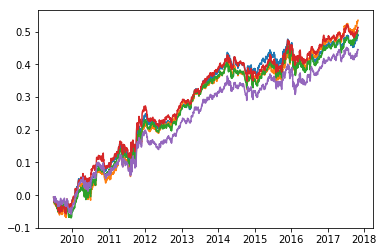

In [7]:
plt.figure()
plt.plot(comb1.best_results_rets.dropna().cumsum())
plt.show()

In [8]:
run1.analyze_parameters()

,Param,Val,Count,MeanTotalRet,MeanSharpe,no_stat
0,holding_period,3,378,0.667858,0.052023,-999.0
1,holding_period,5,378,0.669198,0.056120,-999.0
2,holding_period,7,378,0.600380,0.055286,-999.0
3,holding_period,9,378,0.534446,0.052257,-999.0
4,model,"{u'max_features': 0.5, u'type': u'tree', u'min...",504,0.658084,0.058381,-999.0
5,model,"{u'max_features': 0.8, u'type': u'tree', u'min...",504,0.669449,0.059415,-999.0
6,model,{u'type': u'reg'},504,0.526377,0.043968,-999.0
7,mult_vals,False,504,0.678318,0.062748,-999.0
8,mult_vals,"[0.002, -0.001]",504,0.599668,0.050092,-999.0
9,mult_vals,"[0.002, 0]",504,0.575925,0.048924,-999.0


In [5]:
run1 = RunManagerGCP('StatArbStrategy2', 'run_0007', test_periods=0)
run2 = RunManagerGCP('StatArbStrategy2', 'run_0012', test_periods=0)

In [25]:
run1.import_return_frame()
run2.import_return_frame()

In [26]:
inds = run2.returns.index

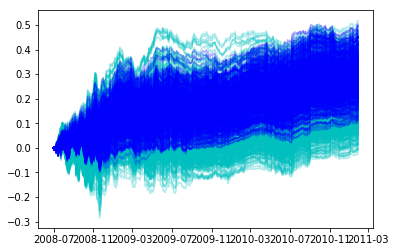

In [28]:
plt.figure()
plt.plot(run2.returns.dropna().cumsum(), 'c', alpha=0.3)
plt.plot(run1.returns.loc[inds].dropna().cumsum(), 'b', alpha=0.3)

plt.show()

## Look at correlations between strategies and returns

In [21]:
run1 = RunManagerGCP('StatArbStrategy2', 'run_0007')

In [22]:
comb1 = CombinationSearch()
comb1.add_run(run1)
comb1.start(10, 'mean')

  0%|          | 0/1 [00:00<?, ?it/s]

Reading and aggregating runs...


  0%|          | 0/10 [00:00<?, ?it/s]

Finished aggregating runs...


100%|██████████| 10/10 [01:30<00:00,  9.14s/it]


In [130]:
## Iterate over date periods
returns = run1.returns.dropna()

In [186]:
def get_returns(train_dates, test_dates, returns, corr_filter_val=0.05):
    train = returns.loc[train_dates]
    test = returns.loc[test_dates]
    # Get correlations and filter redundant information
    correlations = train.corr().abs().unstack().reset_index()
    correlations.columns = ['ColA', 'ColB', 'Correlation']
    correlations.ColA = correlations.ColA.astype(int)
    correlations.ColB = correlations.ColB.astype(int)
    correlations = correlations[correlations.ColA < correlations.ColB]

    # Filter by correlation rank
    corr2 = correlations.copy()
    corr2['CorrRank'] = corr2.Correlation.rank(pct=True)
    corr2 = corr2.sort_values('CorrRank')
    corr2 = corr2[corr2.CorrRank < corr_filter_val]

    # Add combined returns
    corr2.loc[:, 'Rets'] = ((train.iloc[:, corr2.ColA].values + train.iloc[:, corr2.ColB].values) / 2.).sum(axis=0)
    corr2['RetsRank'] = corr2.Rets.rank(pct=True)
    corr2 = corr2.sort_values('RetsRank', ascending=False)

    # Get a set of the top 5
    new_cols = set(corr2.ColA.iloc[:5]).union(corr2.ColB.iloc[:5])
    return test.iloc[:, list(new_cols)].mean(axis=1)

In [189]:
start_index = 300
test_period_len = 10

all_dates = returns.index

output2 = pd.Series()

x1 = start_index
x2 = x1 + test_period_len

while True:
    train_dates = all_dates[:x1]
    test_dates = all_dates[x1:x2]
    print(test_dates[0])

    output2 = output2.append(get_returns(train_dates, test_dates, returns))
    
    x1 = int(x2)
    x2 = x2 + test_period_len

    if x1 > len(all_dates):
        break

2009-09-09 00:00:00
2009-09-23 00:00:00
2009-10-07 00:00:00
2009-10-21 00:00:00
2009-11-04 00:00:00
2009-11-18 00:00:00
2009-12-03 00:00:00
2009-12-17 00:00:00
2010-01-04 00:00:00
2010-01-19 00:00:00
2010-02-02 00:00:00
2010-02-17 00:00:00
2010-03-03 00:00:00
2010-03-17 00:00:00
2010-03-31 00:00:00
2010-04-15 00:00:00
2010-04-29 00:00:00
2010-05-13 00:00:00
2010-05-27 00:00:00
2010-06-11 00:00:00
2010-06-25 00:00:00
2010-07-12 00:00:00
2010-07-26 00:00:00
2010-08-09 00:00:00
2010-08-23 00:00:00
2010-09-07 00:00:00
2010-09-21 00:00:00
2010-10-05 00:00:00
2010-10-19 00:00:00
2010-11-02 00:00:00
2010-11-16 00:00:00
2010-12-01 00:00:00
2010-12-15 00:00:00
2010-12-30 00:00:00
2011-01-13 00:00:00
2011-01-28 00:00:00
2011-02-11 00:00:00
2011-02-28 00:00:00
2011-03-14 00:00:00
2011-03-28 00:00:00
2011-04-11 00:00:00
2011-04-26 00:00:00
2011-05-10 00:00:00
2011-05-24 00:00:00
2011-06-08 00:00:00
2011-06-22 00:00:00
2011-07-07 00:00:00
2011-07-21 00:00:00
2011-08-04 00:00:00
2011-08-18 00:00:00


IndexError: index 0 is out of bounds for axis 0 with size 0

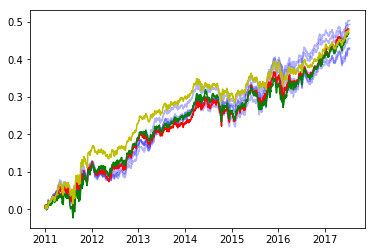

In [192]:
start_date = dt.date(2011, 1, 1)
plt.figure()
plt.plot(comb1.best_results_rets.loc[start_date:].dropna().cumsum(), 'b', alpha=0.3)
plt.plot(output.loc[start_date:].cumsum(), 'r')
plt.plot(output2.loc[start_date:].cumsum(), 'g')
plt.plot(output3.loc[start_date:].cumsum(), 'y')
plt.show()

In [166]:
output.mean() / output.std()

0.068425901508523443

In [183]:
x = rollup_returns(comb1.best_results_rets.dropna())
x['year'] = x.sum(axis=1)
x

Qtr,1,2,3,4,year
Year,,,,,
2009,NaN,NaN,-0.040312,0.016159,-0.024153
2010,0.068816,-0.005065,0.070645,-0.013370,0.121027
2011,0.044237,0.011423,-0.017711,0.078239,0.116188
2012,-0.023788,-0.003973,0.019205,0.057194,0.048638
2013,-0.006856,0.051572,0.024483,0.016985,0.086184
2014,0.042699,-0.005395,-0.020146,-0.011250,0.005908
2015,0.013321,0.036602,-0.025292,0.072080,0.096711
2016,-0.005185,0.000361,0.007288,0.036665,0.039129
2017,0.017957,0.016503,0.003533,NaN,0.037994


In [184]:
x = rollup_returns(pd.DataFrame(output))
x['year'] = x.sum(axis=1)
x

Qtr,1,2,3,4,year
Year,,,,,
2009,NaN,NaN,-0.006913,0.010743,0.003830
2010,0.052998,-0.019496,0.068198,-0.027882,0.073817
2011,0.036973,0.018595,-0.013254,0.073107,0.115421
2012,-0.015796,0.014823,0.007639,0.061590,0.068255
2013,-0.009182,0.024542,0.020989,0.008014,0.044362
2014,0.049802,0.001636,-0.019364,-0.005369,0.026705
2015,0.015937,0.039467,-0.016223,0.060211,0.099392
2016,0.000864,0.011515,-0.000230,0.041643,0.053792
2017,0.042559,0.027334,0.003395,NaN,0.073288


In [208]:
dd = returns.unstack().reset_index()
dd.columns = ['Col', 'Date', 'Ret']
dd['NextRet'] = dd.Ret.shift(1).dropna()
dd = dd[dd.Col == dd.Col.shift(1)]

In [206]:
from gearbox import find_quantiles

In [209]:
find_quantiles(dd.Ret, dd.NextRet, 10)

,Min,Max,Mean,Median,SD,Obs
0,-0.056290,-0.004531,0.000038,-0.000197,0.007349,114358
1,-0.004531,-0.002553,0.000008,-0.000028,0.004541,114358
2,-0.002553,-0.001409,0.000134,0.000100,0.003945,114357
3,-0.001409,-0.000544,0.000186,0.000158,0.003707,114358
4,-0.000544,0.000216,0.000227,0.000207,0.003596,114357
5,0.000216,0.000978,0.000261,0.000233,0.003650,114358
6,0.000978,0.001852,0.000263,0.000235,0.003747,114357
7,0.001852,0.003031,0.000374,0.000332,0.004051,114358
8,0.003031,0.005163,0.000618,0.000480,0.004741,114357
9,0.005163,0.088292,0.000947,0.000626,0.008383,114358


In [224]:
z = pd.DataFrame(output)
z.columns = ['ret']
z['alloc'] = np.where(output >= 0.002, 1.50, np.where(output < -0.1, 0.85, 1))
z['alloc'] = z.alloc.shift(1).fillna(1)
z['ret2'] = z.ret * z.alloc

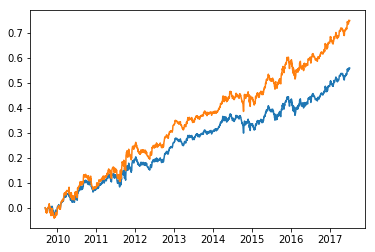

In [225]:
plt.figure()
plt.plot(z.ret.cumsum())
plt.plot(z.ret2.cumsum())
plt.show()

In [226]:
z1 = rollup_returns(z, 0)
z1['year'] = z1.sum(axis=1)
z1

Qtr,1,2,3,4,year
Year,,,,,
2009,NaN,NaN,-0.006913,0.010743,0.003830
2010,0.052998,-0.019496,0.068198,-0.027882,0.073817
2011,0.036973,0.018595,-0.013254,0.073107,0.115421
2012,-0.015796,0.014823,0.007639,0.061590,0.068255
2013,-0.009182,0.024542,0.020989,0.008014,0.044362
2014,0.049802,0.001636,-0.019364,-0.005369,0.026705
2015,0.015937,0.039467,-0.016223,0.060211,0.099392
2016,0.000864,0.011515,-0.000230,0.041643,0.053792
2017,0.042559,0.027334,0.003395,NaN,0.073288


In [227]:
z2 = rollup_returns(z, 2)
z2['year'] = z2.sum(axis=1)
z2

Qtr,1,2,3,4,year
Year,,,,,
2009,NaN,NaN,-0.007902,0.006581,-0.001321
2010,0.070479,-0.018306,0.075367,-0.041499,0.086041
2011,0.043341,0.030170,0.000810,0.087717,0.162038
2012,-0.020537,0.020699,0.017678,0.066776,0.084615
2013,-0.016161,0.030781,0.024784,0.010326,0.049730
2014,0.049701,0.014506,-0.020848,0.012919,0.056279
2015,0.023097,0.049047,-0.006971,0.084080,0.149252
2016,-0.006055,0.020807,0.004579,0.052721,0.072053
2017,0.047924,0.038959,0.003395,NaN,0.090277


In [7]:
RunManagerGCP.get_run_names('StatArbStrategy2')

,Run,RunDate,Completed,Description,Starred
0,run_0001,2018-02-15,True,"Smart factor, sector 20",
1,run_0002,2018-02-15,True,"Smart factor, all sectors",
2,run_0003,2018-02-22,True,"New run with smart factor, sector 20",
3,run_0004,2018-02-20,False,"New run with smart factor, sector 25",
4,run_0005,2018-02-20,False,"New run with smart factor, sector 45",
5,run_0007,2018-02-23,True,"Sector 20, new params, more features for sort",
6,run_0009,2018-02-24,True,"Bayes, Sector 20",


In [6]:
#drop_params = [('holding_period', 5), ('holding_period', 7), ('holding_period', 9), ('model', "{u'type': u'reg'}")]
drop_params = []

In [8]:
run1 = RunManagerGCP('StatArbStrategy2', 'run_0007', start_year=2011)
run2 = RunManagerGCP('StatArbStrategy2', 'run_0009', start_year=2011)

run1.import_return_frame()
run2.import_return_frame()

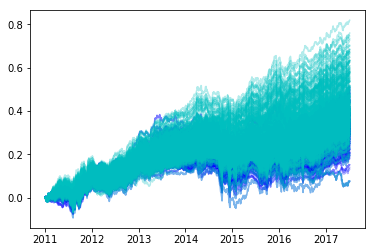

In [9]:
plt.figure()
plt.plot(run2.returns.dropna().cumsum(), 'b', alpha=0.3)
plt.plot(run1.returns.dropna().cumsum(), 'c', alpha=0.3)
plt.show()

In [30]:
comb1 = CombinationSearch()
comb1.add_run(run1)
comb1.start(10, 'mean')

  0%|          | 0/1 [00:00<?, ?it/s]

Reading and aggregating runs...


  0%|          | 0/10 [00:00<?, ?it/s]

Finished aggregating runs...


100%|██████████| 10/10 [01:04<00:00,  6.61s/it]


In [31]:
comb2 = CombinationSearch()
comb2.add_run(run2)
comb2.start(10, 'mean')

  0%|          | 0/1 [00:00<?, ?it/s]

Reading and aggregating runs...


  0%|          | 0/10 [00:00<?, ?it/s]

Finished aggregating runs...


100%|██████████| 10/10 [01:01<00:00,  6.10s/it]


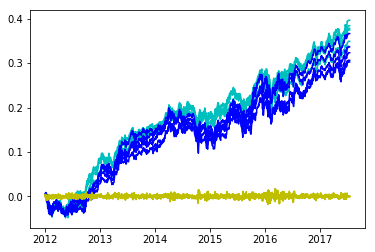

In [32]:
r = (comb1.best_results_rets + comb2.best_results_rets) / 2.

plt.figure()
plt.plot(comb1.best_results_rets.dropna().cumsum(), 'c')
plt.plot(comb2.best_results_rets.dropna().cumsum(), 'b')
plt.plot(r, 'y')
plt.show()

In [23]:
get_stats(comb1.best_results_rets.dropna())

,0,1,2,3,4
Total,0.1966,0.2379,0.1869,0.2200,0.1894
Mean,0.0001,0.0002,0.0001,0.0002,0.0001
Std,0.0041,0.0041,0.0040,0.0041,0.0040
Skew,0.2379,0.3283,0.2679,0.2194,0.2679
Kurt,3.3900,3.7600,3.4000,3.6500,3.5900
Sharpe,0.5523,0.6664,0.5282,0.6167,0.5460
Sortino,0.9427,1.1487,0.9052,1.0468,0.9320
MinRet,-0.0170,-0.0174,-0.0178,-0.0178,-0.0155
WinP,0.5122,0.5251,0.5101,0.5259,0.5165
DD%,-0.0715,-0.0787,-0.0717,-0.0758,-0.0838


In [24]:
get_stats(comb2.best_results_rets.dropna())

,0,1,2,3,4
Total,0.3662,0.3024,0.3362,0.3063,0.3232
Mean,0.0003,0.0002,0.0002,0.0002,0.0002
Std,0.0037,0.0037,0.0037,0.0037,0.0036
Skew,-0.0006,-0.0197,-0.0032,0.0097,0.0317
Kurt,2.2600,1.9500,2.5500,2.3000,2.0700
Sharpe,1.1246,0.9428,1.0406,0.9560,1.0264
Sortino,1.9498,1.6237,1.7982,1.6477,1.7814
MinRet,-0.0194,-0.0186,-0.0197,-0.0176,-0.0176
WinP,0.5287,0.5115,0.5316,0.5187,0.5251
DD%,-0.0762,-0.0794,-0.0669,-0.0786,-0.0667


In [27]:
get_stats(r.dropna())

,0,1,2,3,4
Total,0.2814,0.2702,0.2615,0.2631,0.2563
Mean,0.0002,0.0002,0.0002,0.0002,0.0002
Std,0.0032,0.0032,0.0032,0.0032,0.0031
Skew,0.2359,0.2320,0.2294,0.1595,0.2105
Kurt,3.8400,3.8900,3.8900,3.8100,3.8600
Sharpe,1.0040,0.9581,0.9300,0.9348,0.9307
Sortino,1.7487,1.6607,1.6145,1.6022,1.6060
MinRet,-0.0160,-0.0158,-0.0172,-0.0158,-0.0149
WinP,0.5237,0.5201,0.5208,0.5259,0.5287
DD%,-0.0607,-0.0713,-0.0629,-0.0713,-0.0634


In [8]:
params = run1.analyze_parameters()
params

,Param,Val,Count,MeanTotalRet,MeanSharpe,no_stat
0,holding_period,3,126,0.714483,0.057783,-999.0
1,holding_period,5,126,0.740677,0.064534,-999.0
2,holding_period,7,126,0.707251,0.066481,-999.0
3,holding_period,9,126,0.660230,0.065659,-999.0
4,model,"{u'max_features': 0.5, u'type': u'tree', u'min...",168,0.738919,0.067894,-999.0
5,model,"{u'max_features': 0.8, u'type': u'tree', u'min...",168,0.770677,0.070665,-999.0
6,model,{u'type': u'reg'},168,0.607384,0.052284,-999.0
7,per_side_count,10,168,0.785889,0.058984,-999.0
8,per_side_count,20,168,0.699404,0.065104,-999.0
9,per_side_count,30,168,0.631687,0.066756,-999.0


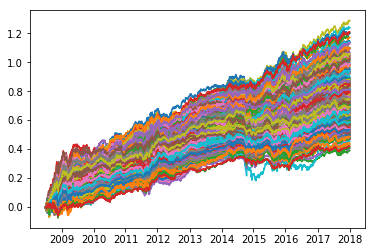

In [9]:
plt.figure()
plt.plot(run1.returns.dropna().cumsum())
plt.show()

In [10]:
comb1 = CombinationSearch()
comb1.add_run(run1)
comb1.start(10, 'mean')

  0%|          | 0/1 [00:00<?, ?it/s]

Reading and aggregating runs...


  0%|          | 0/10 [00:00<?, ?it/s]

Finished aggregating runs...


100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


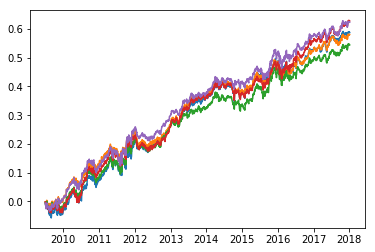

In [11]:
plt.figure()
plt.plot(comb.best_results_rets.dropna().cumsum())
plt.show()

In [12]:
df = rollup_returns(comb.best_results_rets)
df['year'] = df.sum(axis=1)
df

Qtr,1,2,3,4,year
Year,,,,,
2008,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,-0.035035,0.002374,-0.032660
2010,0.060349,-0.018950,0.074671,-0.009509,0.106561
2011,0.048116,0.019280,-0.023417,0.085801,0.129780
2012,-0.016201,0.005943,0.016505,0.053475,0.059722
2013,0.007962,0.043971,0.032185,0.011777,0.095895
2014,0.043623,-0.002558,-0.022871,0.003104,0.021298
2015,0.018353,0.037376,-0.014505,0.060559,0.101782
2016,0.002590,-0.006851,0.010940,0.036472,0.043150


# Analysis of Stats in All Output

In [8]:
run1.import_all_output()

In [32]:
# Exposure columns
expcols = [x for x in run1.all_output.columns if x.find('Exp') > -1]
turncols = [x for x in run1.all_output.columns if x.find('Turnover') > -1]
opencols = [x for x in run1.all_output.columns if x.find('OpenPositions') > -1]
longpl = [x for x in run1.all_output.columns if x.find('LongPL') > -1]
shortpl = [x for x in run1.all_output.columns if x.find('ShortPL') > -1]

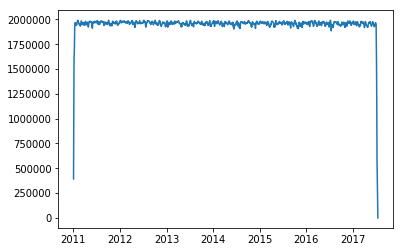

In [36]:
plt.figure()
plt.plot(run1.all_output[expcols].mean(axis=1))
plt.show()

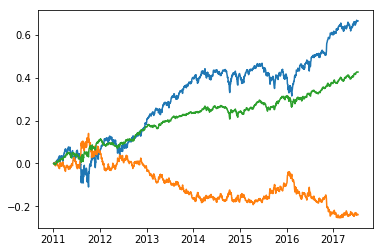

In [34]:
plt.figure()
plt.plot(run1.all_output[longpl].mean(axis=1).cumsum())
plt.plot(run1.all_output[shortpl].mean(axis=1).cumsum())
plt.plot(run1.all_output[longpl].mean(axis=1).cumsum() + run1.all_output[shortpl].mean(axis=1).cumsum())
plt.show()